In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
count = 0
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if count != 10:
            print(os.path.join(dirname, filename))
            count += 1

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/dummy_sub.csv
/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/train_labels.csv
/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/test/6d66297e.jpg
/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/test/ed9f6250.jpg
/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/test/30503f9d.jpg
/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/test/74b88387.jpg
/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/test/385082b9.jpg
/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/test/bb126871.jpg
/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/test/85fe3a81.jpg
/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/test/895567eb.jpg


In [3]:
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from IPython.display import clear_output, display
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import albumentations as A
import math
import cv2

%matplotlib inline

2025-06-12 19:58:03.784522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749758284.038638      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749758284.111121      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
df_labels = pd.read_csv('/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/train_labels.csv')
df_labels

,filename,label
0,39d30b68.jpg,Naeimi
1,4a9853bd.jpg,Goat
2,d88facaa.jpg,Roman
3,a3f4f4af.jpg,Roman
4,16b31730.jpg,Naeimi
...,...,...
677,2c0ea8a4.jpg,Naeimi
678,fc48f9e0.jpg,Goat
679,4baa1e02.jpg,Naeimi
680,8c0907bc.jpg,Naeimi


In [5]:
df_labels['label'].unique()

array(['Naeimi', 'Goat', 'Roman', 'Harri', 'Sawakni', 'Barbari', 'Najdi'],
      dtype=object)

In [6]:
df_labels.replace({'Naeimi':0, 'Sawakni':1, 'Goat':2, 'Najdi':3, 'Barbari':4, 'Roman':5, 'Harri':6},
                  inplace=True)

/tmp/ipykernel_35/2227075817.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_labels.replace({'Naeimi':0, 'Sawakni':1, 'Goat':2, 'Najdi':3, 'Barbari':4, 'Roman':5, 'Harri':6},


In [7]:
df_labels['label'].unique()

array([0, 2, 5, 6, 1, 4, 3])

In [8]:
def most_frequent(lst):
    return Counter(lst).most_common(1)[0][0]

train_dir = '/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/train/'
X = []
count = 0
Min = np.random.rand(1500,1500,3)
shapes = []

for image_filename in df_labels['filename']:
    img_path = os.path.join(train_dir, image_filename)
    img = Image.open(img_path)
    img_arr = np.array(img)
    if count < 10:
        print(img_arr.shape)
        count += 1
    if Min.shape > img_arr.shape:
        Min = img_arr
    shapes.append(img_arr.shape)

print()
print("Minimum shape:",Min.shape)
most_frequent_shape = most_frequent(shapes)
print("Most frequent shape:",most_frequent_shape)

(1601, 900, 3)
(1200, 900, 3)
(113, 85, 3)
(141, 146, 3)
(240, 294, 3)
(565, 563, 3)
(95, 92, 3)
(127, 126, 3)
(193, 261, 3)
(140, 140, 3)

Minimum shape: (49, 79, 3)
Most frequent shape: (225, 225, 3)


Original shape: (49, 79, 3)
Resized shape: (225, 225, 3)


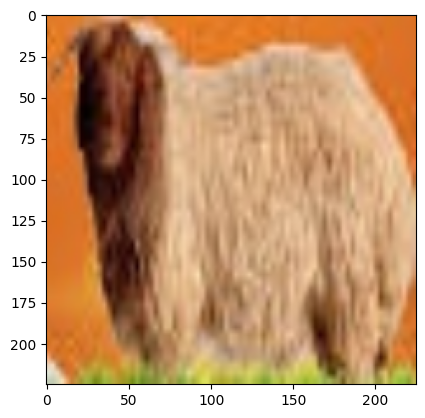

In [9]:
print("Original shape:",Min.shape)
Min = cv2.resize(Min, ((most_frequent_shape[1], most_frequent_shape[0])))
print("Resized shape:",Min.shape)
plt.imshow(Min)
plt.show()

(225, 225, 3)


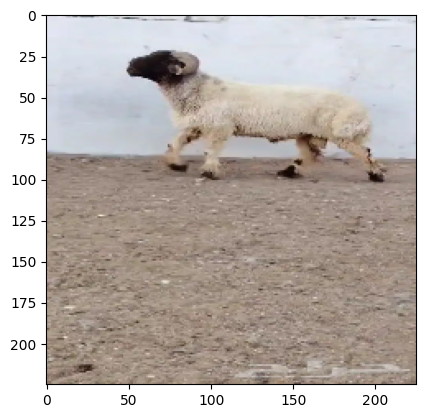

In [10]:
img_path = os.path.join(train_dir, '00630916.jpg')
img = Image.open(img_path)
img_arr = np.array(img)
resized_img = cv2.resize(img_arr, ((most_frequent_shape[1], most_frequent_shape[0])))
print(resized_img.shape)

plt.imshow(resized_img)
plt.show()

In [11]:
resized_images = []
count = 0

for image_filename in df_labels['filename']:
    img_path = os.path.join(train_dir, image_filename)
    img = Image.open(img_path)
    img_arr = np.array(img)
    if img_arr.shape != most_frequent_shape:
        img_arr = cv2.resize(img_arr, ((most_frequent_shape[1], most_frequent_shape[0])))
        count += 1
    resized_images.append(img_arr)

print(f"Resized {count} images to {most_frequent_shape}.")
print(f"Length of resized_images is {len(resized_images)}")

Resized 616 images to (225, 225, 3).
Length of resized_images is 682


In [12]:
transform = A.Compose([
    A.Resize(height=most_frequent_shape[0], width=most_frequent_shape[1]),
    A.OneOf([
        A.HorizontalFlip(p=0.9),
        A.Rotate(limit=30, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.9),
    ], p=1.0),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.9),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=25, val_shift_limit=20, p=0.9),
        A.CLAHE(clip_limit=3.0, tile_grid_size=(6, 6), p=0.6),
        A.RandomGamma(gamma_limit=(70, 130), p=0.6),
        A.ChannelShuffle(p=0.2)
    ], p=0.9),
    A.OneOf([
        A.GaussNoise(var_limit=(20.0, 60.0), p=0.6),
        A.MultiplicativeNoise(multiplier=[0.8, 1.2], p=0.5),
        A.ISONoise(color_shift=(0.01, 0.08), intensity=(0.1, 0.7), p=0.4)
    ], p=0.6),
    A.OneOf([
        A.Blur(blur_limit=5, p=0.4),
        A.MotionBlur(blur_limit=5, p=0.4),
        A.GaussianBlur(blur_limit=5, p=0.4),
        A.MedianBlur(blur_limit=3, p=0.3)
    ], p=0.4)
])


/tmp/ipykernel_35/1956736670.py:5: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=30, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.9),
/tmp/ipykernel_35/1956736670.py:15: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(20.0, 60.0), p=0.6),


In [13]:
labels = df_labels['label'].to_numpy()
labels = labels.reshape(-1)
labels.shape

(682,)

In [14]:
X = []
Y = []

for i in range(len(resized_images)):
    X.append(resized_images[i])
    Y.append(labels[i])
    for j in range(3):
        augmented_img = transform(image=resized_images[i])['image']
        X.append(augmented_img)
        Y.append(labels[i])

X = np.array(X)
Y = np.array(Y)
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (2728, 225, 225, 3)
Y shape: (2728,)


In [15]:
perm = np.random.permutation(len(X))
X = X[perm]
Y = Y[perm]

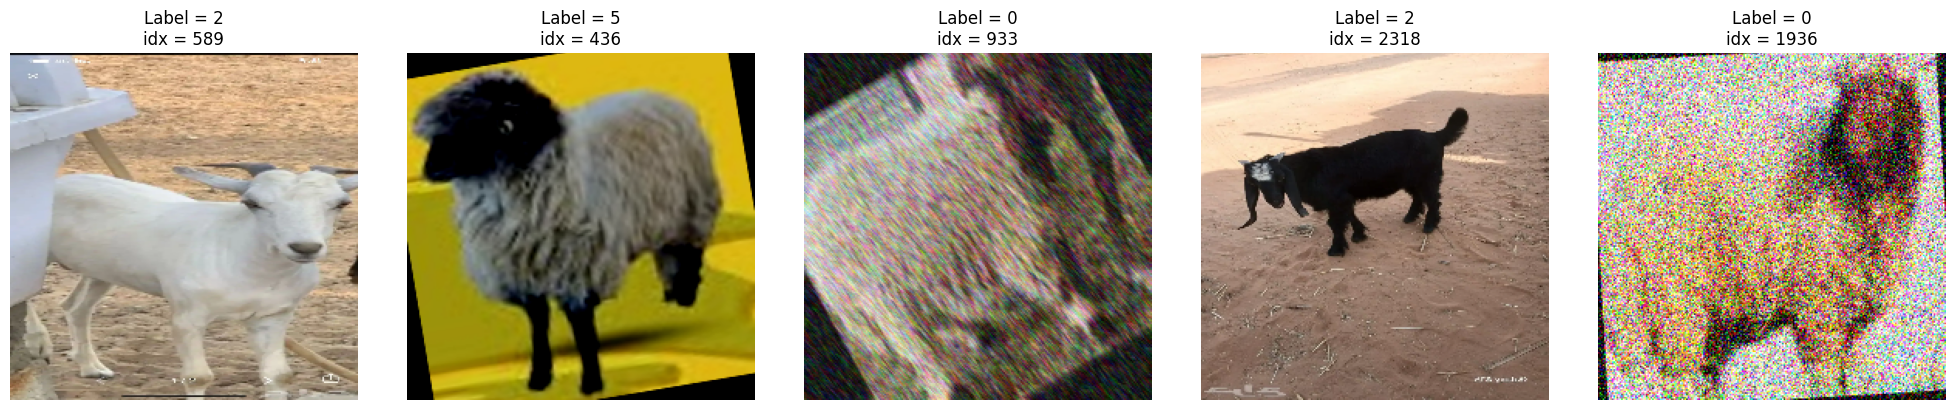

In [16]:
assert len(X) == len(Y)
indices = np.random.choice(len(X), size=5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(20, 4)) 

for ax, idx in zip(axes, indices):
    ax.imshow(X[idx])
    ax.set_title(f"Label = {Y[idx]}\nidx = {idx}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [17]:
# idx = 1369
# label = 0

# for i in range(idx-5, idx+6):
#     if Y[i] == label:
#         plt.imshow(X[i])
#         plt.title(f"Label = {Y[i]} with i = {i}")
#         plt.show()

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42)

X_train = X_train / 255.0
X_val = X_val / 255.0

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("Y_train shape:", Y_train.shape)
print("Y_val shape:", Y_val.shape)


X_train shape: (2182, 225, 225, 3)
X_val shape: (546, 225, 225, 3)
Y_train shape: (2182,)
Y_val shape: (546,)


In [19]:
print(Counter(Y_train))

Counter({0: 804, 2: 337, 1: 272, 3: 231, 5: 226, 6: 196, 4: 116})


In [20]:
classes = np.unique(Y_train)
weights = compute_class_weight("balanced", classes=classes, y=Y_train)
class_weight = dict(zip(classes, weights))

class_weights_softened = {}
for k, v in class_weight.items():
    class_weights_softened[k] = 1 + 0.5 * (v - 1) 

In [21]:
class F1Score(keras.metrics.Metric):
    def __init__(self, num_classes=7, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.tp = self.add_weight(name="tp", shape=(num_classes,), initializer="zeros")
        self.fp = self.add_weight(name="fp", shape=(num_classes,), initializer="zeros")
        self.fn = self.add_weight(name="fn", shape=(num_classes,), initializer="zeros")
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.cast(tf.reshape(y_pred, [-1]), tf.int32)
        y_true_o = tf.one_hot(y_true, self.num_classes)
        y_pred_o = tf.one_hot(y_pred, self.num_classes)
        tp = tf.reduce_sum(y_true_o * y_pred_o, axis=0)
        fp = tf.reduce_sum((1 - y_true_o) * y_pred_o, axis=0)
        fn = tf.reduce_sum(y_true_o * (1 - y_pred_o), axis=0)
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = tf.math.divide_no_nan(self.tp, self.tp + self.fp)
        recall    = tf.math.divide_no_nan(self.tp, self.tp + self.fn)
        f1_per_class = 2 * precision * recall / tf.math.maximum(precision + recall, tf.keras.backend.epsilon())
        return tf.reduce_mean(f1_per_class)

    def reset_states(self):
        for v in (self.tp, self.fp, self.fn):
            v.assign(tf.zeros_like(v))



class LiveLossF1Plot(keras.callbacks.Callback):
    """
    Callback that plots training & validation loss,
    F1-score, and learning rate after each epoch.
    """
    def __init__(self, pause=0.1):
        super().__init__()
        self.pause = pause
        self.train_losses = []
        self.val_losses   = []
        self.train_f1s    = []
        self.val_f1s      = []
        self.lrs          = []

    def on_train_begin(self, logs=None):
        self.fig, (self.ax_loss, self.ax_f1, self.ax_lr) = plt.subplots(3, 1, figsize=(8, 12))
        self.fig.subplots_adjust(hspace=0.5)
        display(self.fig)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # append metrics
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(  logs.get('val_loss'))
        self.train_f1s.append(   logs.get('f1_score'))
        self.val_f1s.append(     logs.get('val_f1_score'))

        # grab current LR
        opt = self.model.optimizer
        lr = opt.learning_rate
        if callable(lr):
            lr = lr(opt.iterations)
        self.lrs.append(tf.keras.backend.get_value(lr))

        # redraw
        clear_output(wait=True)

        # Loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.train_losses, marker='o', label='Train Loss')
        self.ax_loss.plot(self.val_losses,   marker='o', label='Val Loss')
        self.ax_loss.set(title='Loss over Epochs', xlabel='Epoch', ylabel='Loss')
        self.ax_loss.legend(); self.ax_loss.grid(True)

        # F1 Score
        self.ax_f1.clear()
        self.ax_f1.plot(self.train_f1s, marker='o', label='Train F1')
        self.ax_f1.plot(self.val_f1s,   marker='o', label='Val F1')
        self.ax_f1.set(title='F1 Score over Epochs', xlabel='Epoch', ylabel='F1 Score')
        self.ax_f1.legend(); self.ax_f1.grid(True)

        # Learning Rate
        self.ax_lr.clear()
        self.ax_lr.plot(self.lrs, marker='o', label='Learning Rate')
        self.ax_lr.set(title='Learning Rate over Epochs', xlabel='Epoch', ylabel='LR')
        self.ax_lr.legend(); self.ax_lr.grid(True)

        display(self.fig)
        plt.pause(self.pause)

In [22]:
class PredictionRangeCallback(keras.callbacks.Callback):
    """
    Callback that prints the min and max prediction probabilities
    for each class after each epoch (for a softmax head).
    """
    def __init__(self, x_data, batch_size=None, from_logits=True, verbose=1):
        super().__init__()
        self.x_data = x_data
        self.batch_size = batch_size
        self.from_logits = from_logits
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs=None):
        # 1) Get raw preds: shape (num_samples, num_classes)
        preds = self.model.predict(self.x_data,
                                   batch_size=self.batch_size,
                                   verbose=0)

        # 2) If they’re logits, convert to probabilities via softmax
        if self.from_logits:
            preds = tf.nn.softmax(preds, axis=-1).numpy()

        # 3) Compute min/max per class
        n_classes = preds.shape[-1]
        mins = preds.min(axis=0)
        maxs = preds.max(axis=0)

        # 4) Print out a line for each class
        if self.verbose:
            print(f"— Epoch {epoch+1:02d} prediction ranges:")
            for i in range(n_classes):
                print(f"    Class {i}: [{mins[i]:.4f}, {maxs[i]:.4f}]")

In [23]:
class ClippedExponentialDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Learning rate schedule that applies exponential decay but clips at a minimum LR.
    """
    def __init__(self, base_schedule, min_lr):
        super().__init__()
        self.base_schedule = base_schedule
        self.min_lr = min_lr

    def __call__(self, step):
        # Compute decayed lr and clip to minimum
        lr = self.base_schedule(step)
        return tf.math.maximum(lr, self.min_lr)

    def get_config(self):
        return {
            'base_schedule': self.base_schedule,
            'min_lr': self.min_lr,
        }

In [24]:
def make_model(input_dims=(225, 225, 3)):
    reg = keras.regularizers.l2(1e-4)
    inputs = keras.Input(shape=input_dims)
    base = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )
    base.trainable = True

    x = base.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Dense(64, activation='relu', kernel_regularizer=reg)(x)
    x = keras.layers.Dropout(0.25)(x)
    outputs = keras.layers.Dense(7, activation='softmax', kernel_regularizer=reg)(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="resnet50_custom_head")

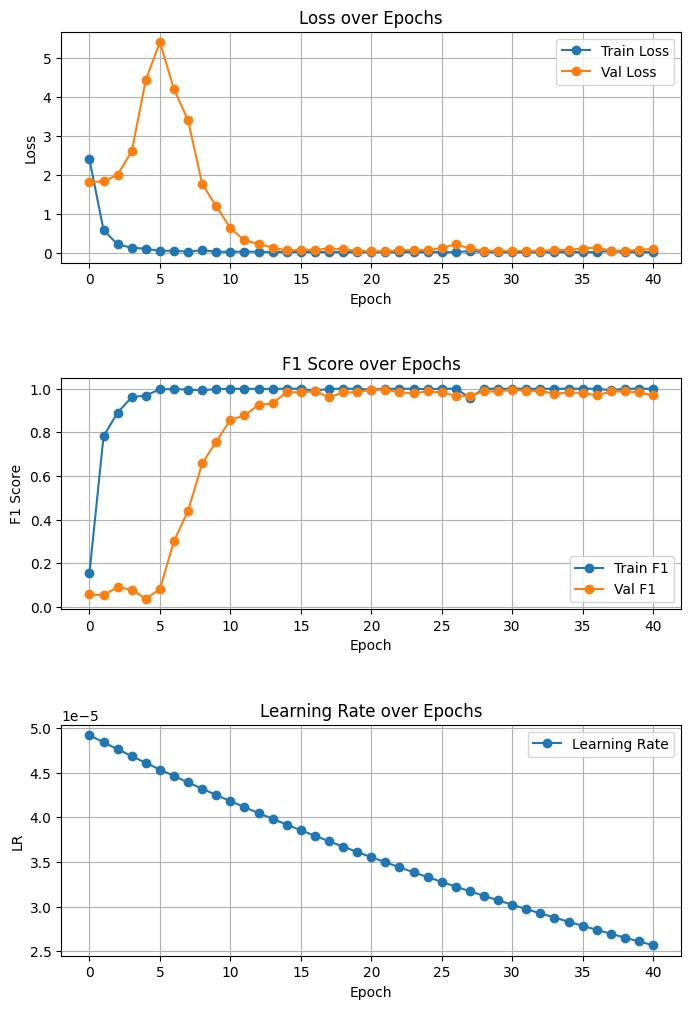

— Epoch 41 prediction ranges:
    Class 0: [0.0000, 1.0000]
    Class 1: [0.0000, 1.0000]
    Class 2: [0.0000, 1.0000]
    Class 3: [0.0000, 1.0000]
    Class 4: [0.0000, 1.0000]
    Class 5: [0.0000, 1.0000]
    Class 6: [0.0000, 1.0000]
69/69 ━━━━━━━━━━━━━━━━━━━━ 32s 469ms/step - f1_score: 0.9980 - loss: 0.0146 - val_f1_score: 0.9700 - val_loss: 0.1011


In [25]:
use_T4_x2_GPU = True

if use_T4_x2_GPU:
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        batch_size     = 32
        steps_per_epoch= math.ceil(X_train.shape[0] / batch_size)
        initial_lr     = 5e-5
        decay_steps    = steps_per_epoch * 10
        decay_rate     = 0.85
        min_lr         = 5e-6

        base_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_lr,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
            staircase=False
        )
        lr_schedule = ClippedExponentialDecay(base_schedule, min_lr)

        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

        live_plot_cb = LiveLossF1Plot(pause=0.1)

        pred_range_cb = PredictionRangeCallback(
            x_data=X_val,
            batch_size=batch_size,
            from_logits=False,
            verbose=1
        )

        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_f1_score',
            mode='max',
            patience=20,
            restore_best_weights=True
        )

        model = make_model(input_dims=(225,225,3))

        model.compile(
            optimizer=optimizer,
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=[F1Score(num_classes=7)]
        )
        history = model.fit(
        x = X_train,
        y = Y_train,
        batch_size= batch_size,
        epochs    = 200,        
        validation_data = (X_val, Y_val),
        callbacks = [
            live_plot_cb,
            pred_range_cb,
            early_stopping,
            
        ],
        class_weight=class_weights_softened
        )

In [26]:
test_dir = '/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/test/'
filenames = []
X_TEST = []

for filename in os.listdir(test_dir):
    filenames.append(filename)
    img_path = os.path.join(test_dir, filename)
    img = Image.open(img_path)
    img_arr = np.array(img)
    resized_img = cv2.resize(img_arr, ((most_frequent_shape[1], most_frequent_shape[0])))
    X_TEST.append(resized_img)

X_test_non_scaled = np.array(X_TEST)
X_test = X_test_non_scaled / 255.0
print(X_test.shape)

(144, 225, 225, 3)


In [27]:
preds = model.predict(X_test)
preds.shape

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


(144, 7)

In [28]:
preds[0]

array([4.2497935e-03, 1.0484096e-03, 6.9480932e-01, 7.0039758e-05,
       6.0604105e-04, 2.9877821e-01, 4.3812359e-04], dtype=float32)

In [29]:
# probs = tf.nn.softmax(preds, axis=1).numpy()
# probs.shape

In [31]:
final_classes = np.argmax(preds, axis=1)

In [32]:
np.unique(final_classes)

array([0, 1, 2, 3, 4, 5, 6])

In [33]:
df_preds = pd.DataFrame({
    'filename': filenames,
    'label': final_classes,
    # **{f'prob_class_{i}': probs[:, i] for i in range(probs.shape[1])}
})
df_preds

,filename,label
0,6d66297e.jpg,2
1,ed9f6250.jpg,0
2,30503f9d.jpg,6
3,74b88387.jpg,2
4,385082b9.jpg,2
...,...,...
139,100bd43a.jpg,5
140,5334f219.jpg,2
141,933339b9.jpg,6
142,8dbe2536.jpg,5


In [34]:
inv_map = {0: 'Naeimi',
           1: 'Sawakni',
           2: 'Goat',
           3: 'Najdi',
           4: 'Barbari',
           5: 'Roman',
           6: 'Harri'}

df_preds.replace(inv_map, inplace=True)
df_preds

,filename,label
0,6d66297e.jpg,Goat
1,ed9f6250.jpg,Naeimi
2,30503f9d.jpg,Harri
3,74b88387.jpg,Goat
4,385082b9.jpg,Goat
...,...,...
139,100bd43a.jpg,Roman
140,5334f219.jpg,Goat
141,933339b9.jpg,Harri
142,8dbe2536.jpg,Roman


In [35]:
df_preds.to_csv('submission3.csv', index=False)